# Livro: Python for Algorithmic Trading

## Dependências

## Especificações da Pesquisa

- Horizonte de previsão: 30 min, 1 hora, 3 horas


## DNN

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 22)                132       
                                                                 
 dense_17 (Dense)            (None, 64)                1472      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,829
Trainable params: 5,829
Non-trainable params: 0
_________________________________________________________________
124/124 [==============================] - 0s 1ms/step - loss: 7.2477 - accuracy: 0.5144


[7.2476725578308105, 0.5144450068473816]

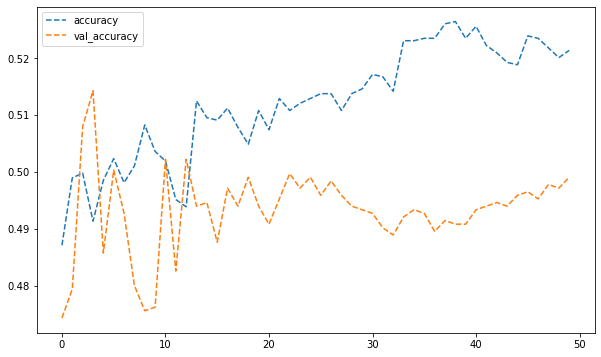

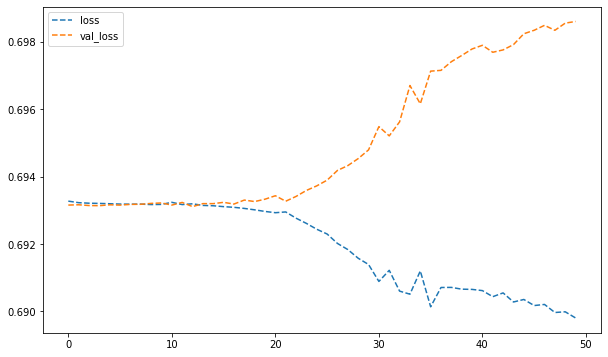

In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np

data = pd.read_csv('/home/bene/MachineLearning/TCC/Base de Dados/BPAC_30m_2021.csv') 
data.head()
symbol = "close"
data = pd.DataFrame(data[symbol])
data.head()
data.rename(columns={symbol: 'price'}, inplace=True)
data.head()
data['return'] = np.log(data['price']/data['price'].shift(1))
data['direction'] = np.where(data['return'] > 0, 1, 0)

lags = 5
cols = []
for lag in range(1, lags + 1):
     col = f'lag_{lag}'
     data[col] = data['return'].shift(lag)
     cols.append(col)
data.dropna(inplace=True)

cutoff = 3952
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std


test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM, Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
import random

optimizer = Adam(learning_rate=0.001)


def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

set_seeds()
model=Sequential()
model.add(Dense(22 ,input_shape=(lags,),activation='relu'))
#https://github.com/fchollet/deep-learning-with-python-notebooks/issues/157
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer= optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

model.fit(training_data[cols],training_data['direction'],epochs=50, verbose=False, validation_split=0.4,shuffle=False)

res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
res[['loss', 'val_loss']].plot(figsize=(10, 6), style='--');

model.evaluate(training_data_[cols], training_data['direction'])


In [19]:
pred = model.predict(X_train_) 
pred = np.where(model.predict(X_train_) > 0.5, 1, 0)
pred = pred.reshape(len(pred),1)
valores_preditos = [] # predicao
valores_reais = [] # direcao
for predicao, direcao in zip(pred, Y_train):
    valores_preditos.append(int(predicao))
    valores_reais.append(int(direcao))

def get_confusion_matrix(reais, preditos, labels):
    if len(labels) > 2:
        return None

    if len(reais) != len(preditos):
        return None
    
    true_class = labels[0]
    negative_class = labels[1]
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for (indice, v_real) in enumerate(reais):
        v_predito = preditos[indice]

        if v_real == true_class:
            tp += 1 if v_predito == v_real else 0
            fp += 1 if v_predito != v_real else 0
        else:
            tn += 1 if v_predito == v_real else 0
            fn += 1 if v_predito != v_real else 0
    
    return np.array([
        [ tp, fp ],
        [ fn, tn ]
    ])

get_confusion_matrix(reais=valores_reais, preditos=valores_preditos, labels=[1,0])

from sklearn.metrics import classification_report
print(classification_report(valores_reais, valores_preditos, labels=[0, 1]))

NameError: name 'X_train_' is not defined